<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Xception_network(Small_version)_ipynb_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [ ]:
! wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

--2023-09-07 14:57:23--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 104.97.45.22, 2600:1409:9800:984::317f, 2600:1409:9800:98c::317f
Connecting to download.microsoft.com (download.microsoft.com)|104.97.45.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M   123MB/s    in 8.8s    

2023-09-07 14:57:32 (89.8 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [ ]:
! ls PetImages

Cat  Dog


In [ ]:
skipped = 0
for files in ("Cat", "Dog"):
  file_path = os.path.join("/content/PetImages", files)
  for fname in os.listdir(file_path):
    img_path = os.path.join(file_path, fname)
    try:
      fobj = open(img_path, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()
    if not is_jfif:
      skipped += 1
      os.remove(img_path)

print("Delete Image lst %d" % skipped)

Delete Image lst 1590


In [ ]:
img_size = (180, 180)
batch_size = 128
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/PetImages",
    validation_split=0.2,
    subset="both",
    image_size = img_size,
    batch_size = batch_size,
    seed = 1337)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


In [ ]:
import matplotlib.pyplot as plt

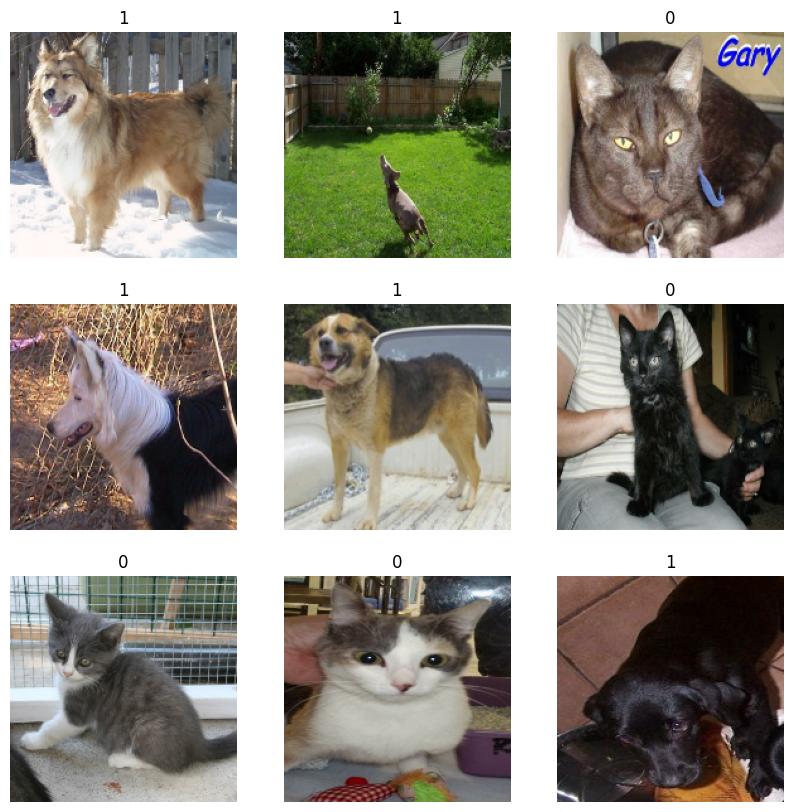

In [ ]:
plt.figure(figsize=(10,10))
for img, lab in train_ds.take(1):
    for x in range(9):
        plt.subplot(3,3, x+1)
        plt.imshow(img[x].numpy().astype("uint8"))
        plt.title(int(lab[x]))
        plt.axis("off")

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomFlip("horizontal")
    ])

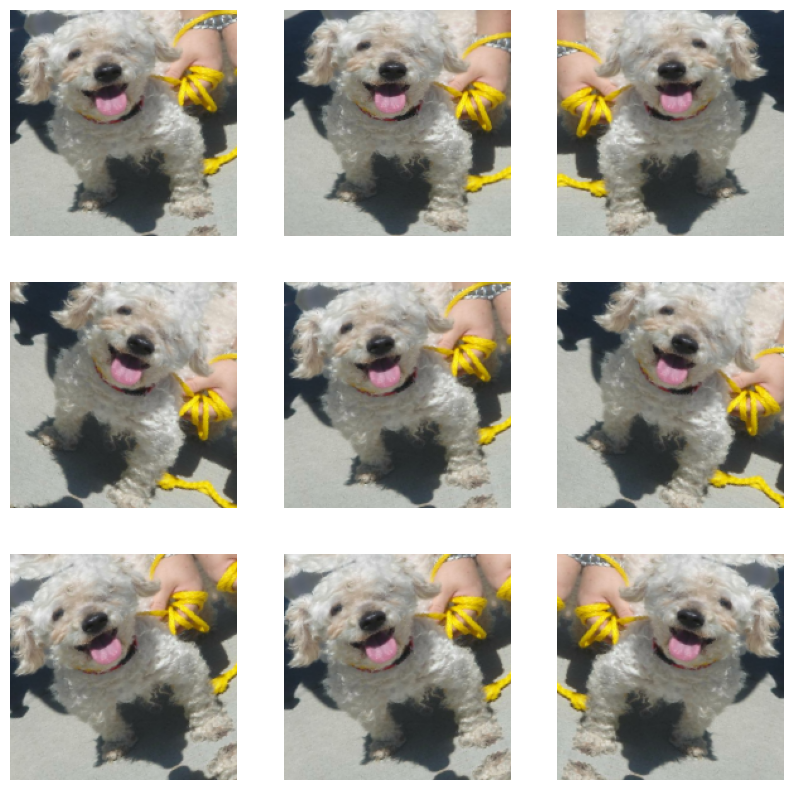

In [ ]:
plt.figure(figsize=(10,10))
for img, _ in train_ds.take(1):
    for x in range(9):
        augment = data_augmentation(img)
        plt.subplot(3,3, x+1)
        plt.imshow(augment[0].numpy().astype("uint8"))
        #plt.title(int(lab[x]))
        plt.axis("off")

In [ ]:
train_ds = train_ds.map(lambda img, lab : (data_augmentation(img), lab), num_parallel_calls = tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

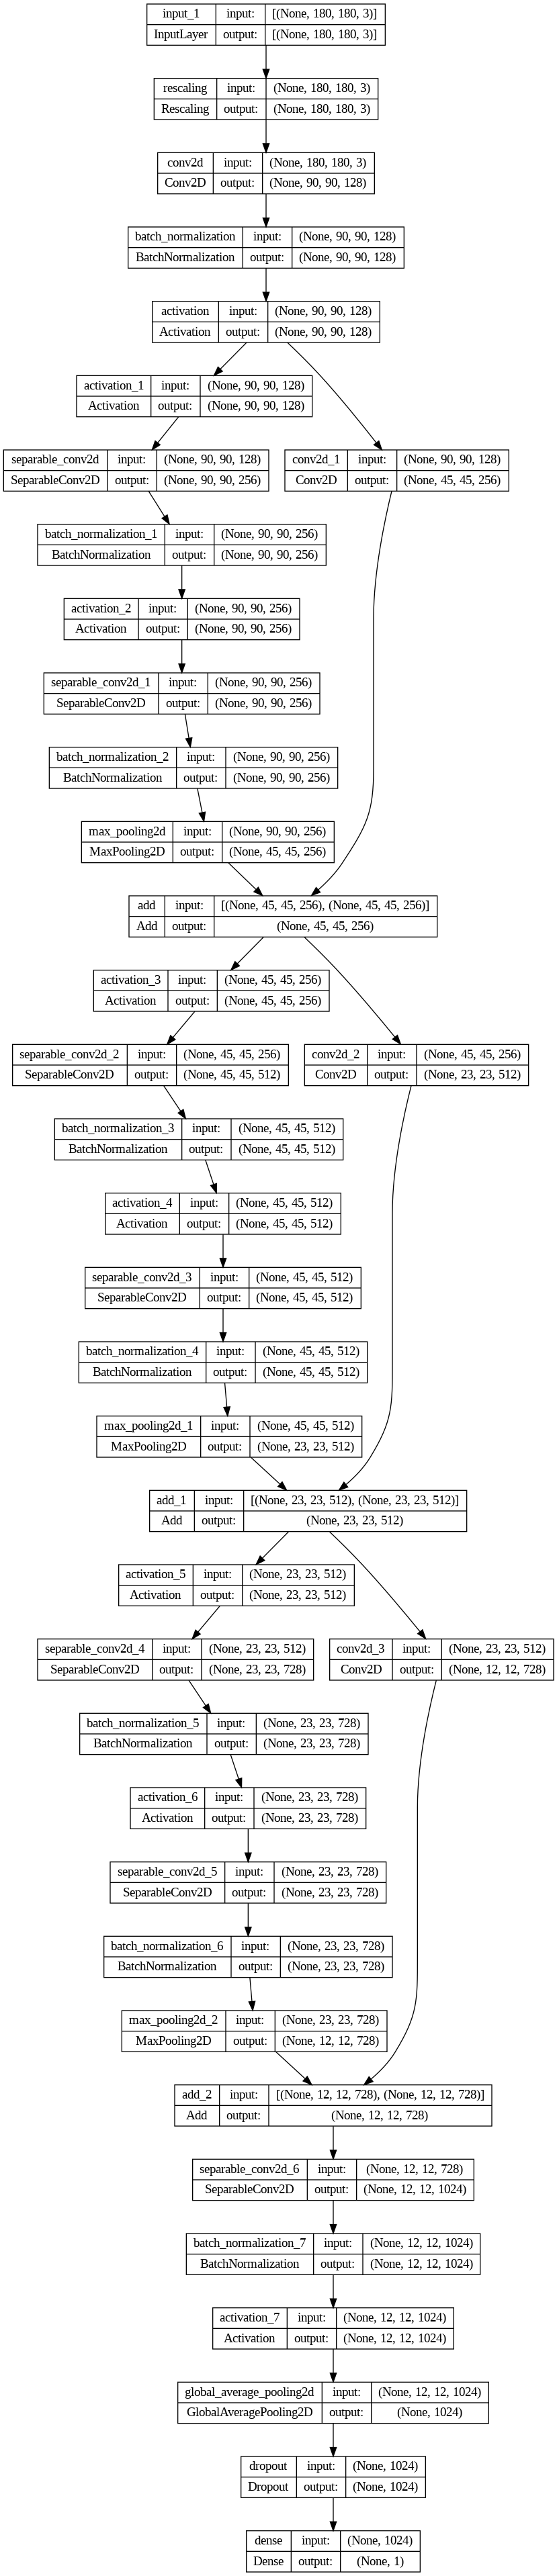

In [ ]:
def make_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=img_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint("save_at{epoch}.keras")]
model.compile(optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = "binary_crossentropy",
    metrics = ["accuracy"])

history = model.fit(train_ds, callbacks = callbacks,  epochs = 25, validation_data = val_ds)

Epoch 1/25
147/147 [==============================] - 249s 1s/step - loss: 0.6336 - accuracy: 0.6573 - val_loss: 0.7563 - val_accuracy: 0.4957
Epoch 2/25
147/147 [==============================] - 208s 1s/step - loss: 0.4717 - accuracy: 0.7769 - val_loss: 1.0356 - val_accuracy: 0.4957
Epoch 3/25
147/147 [==============================] - 208s 1s/step - loss: 0.3735 - accuracy: 0.8357 - val_loss: 1.1774 - val_accuracy: 0.4957
Epoch 4/25
147/147 [==============================] - 209s 1s/step - loss: 0.3049 - accuracy: 0.8715 - val_loss: 0.4276 - val_accuracy: 0.7841
Epoch 5/25
147/147 [==============================] - 208s 1s/step - loss: 0.2590 - accuracy: 0.8913 - val_loss: 1.1993 - val_accuracy: 0.6072
Epoch 6/25
147/147 [==============================] - 215s 1s/step - loss: 0.2241 - accuracy: 0.9071 - val_loss: 0.7199 - val_accuracy: 0.6995
Epoch 7/25
147/147 [==============================] - 208s 1s/step - loss: 0.1998 - accuracy: 0.9184 - val_loss: 0.1898 - val_accuracy: 0.9218